Mount Github files to Google Drive

In [1]:
! rm -rf sample_data; curl -s https://raw.githubusercontent.com/DayongTong/MEAM517_Project_Git/main/sync_project.py > sync_project.py
files = ["spacecraft.py","simulation.py", "dynamic_constraints.py", "kinematic_constraints.py","plot_util.py","logger_util.py","dirtrel.py"]

from sync_project import sync_project
sync_project(files, False)

Mounted at /content/drive


Install Drake

In [1]:
# install pydrake

!curl -s https://raw.githubusercontent.com/mposa/MEAM517/master/colab_drake_setup.py > colab_drake_setup.py
from colab_drake_setup import setup
setup()

<IPython.core.display.Javascript object>

Import Packages

In [2]:
from pydrake.all import eq, MathematicalProgram, Solve, Variable
import matplotlib.pyplot as plt
import numpy as np
import importlib
from pydrake.math import sqrt
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve, SolverType
from pydrake.trajectories import PiecewisePolynomial
from pydrake.solvers.snopt import SnoptSolver
from pydrake.autodiffutils import AutoDiffXd
import pydrake.math as drake_math

In [4]:
import kinematic_constraints
import dynamic_constraints
import plot_util
import logger_util
import dirtrel
importlib.reload(plot_util)
importlib.reload(kinematic_constraints)
importlib.reload(dynamic_constraints)
importlib.reload(logger_util)
importlib.reload(dirtrel)
from kinematic_constraints import (
    AddInitialConstraints,
    AddLandingConstraints
)
from dynamic_constraints import (
    AddCollocationConstraints,
    EvaluateDynamics,
    numeric_eval_dynamics
)
from plot_util import(
    plot_util,
    plot_util_spline,
    plot_3d_trajectory,
    plot_util_overlay,
    plot_util_overlay_all
)
from logger_util import logger_util
from dirtrel import (
    ell_w,
    compute_A,
    compute_B,
    compute_G
)

In [5]:
# set up constants

N = 25                     # number of collocation points
n_x = 9
n_u = 3

r_0 = 3474.8*1000           #radius of Mars (m)
alpha_0 = -23.45*np.pi/180  #longitude 
beta_0 = -2.94*np.pi/180    #latitude 
Vx_0 = 0
Vy_0 = 0
Vz_0 = 0
m_0 = 4000 #15234                  #Mass of rocket (kg)
phi_0 = 90*np.pi/180         #pitch 
psi_0 = 0                    #yaw 

# final position
r_N = 3474.8*1000            #radius of Mars, in km
alpha_N = -23.45*np.pi/180   
beta_N = -2.34*np.pi/180     
Vx_N = 0
Vy_N = 0
Vz_N = 0
phi_N = 90*np.pi/180
psi_N = 0

# initial control input 
T_0 = 0
phidot_0 = 0
psidot_0 = 0

# final control input
T_N = 0
phidot_N = 0
psidot_N = 0

# constraint coefficients
r_min = 3474.8*1000
# h_max = np.inf
h_max = 30
r_max = 3474.8*1000 + h_max   #h_max km above Mars surface
phi_min = -180*np.pi/180   #rad
phi_max = 180*np.pi/180    #rad
psi_min = -180*np.pi/180   #rad
psi_max = 180*np.pi/180    #rad
phidot_min = -10*np.pi/180 #rad/sec
phidot_max = 10*np.pi/180  #rad/sec
psidot_min = -10*np.pi/180 #rad/sec
psidot_max = 10*np.pi/180  #rad/sec
T_min = 4671               #Newton
T_max = 43148              #Newton

initial_state = np.array([r_0,alpha_0,beta_0,Vx_0,Vy_0,Vz_0,m_0,phi_0,psi_0])
final_state = np.array([r_N,alpha_N,beta_N,Vx_N,Vy_N,Vz_N,phi_N,psi_N])
input_limit = np.array([[T_min,phidot_min,psidot_min],[T_max,phidot_max,psidot_max]])
initial_input = np.array([T_0,phidot_0,psidot_0])
final_input = np.array([T_N,phidot_N,psidot_N])

# m = 8321.09        #kg
g = 3.711          #m/s^2
Isp = 302.39       #s (effective specific impulse of the lander, used in mdot equation)


In [114]:
# Initialize Mathematical Program and Add Variables

prog = MathematicalProgram()
x = np.zeros((N,n_x),dtype="object")
u = np.zeros((N,n_u),dtype="object")
dt = np.zeros((1,), dtype="object")

for i in range(N):
    x[i] = prog.NewContinuousVariables(n_x,"x_" + str(i))
    u[i] = prog.NewContinuousVariables(n_u,"u_" + str(i))
dt = prog.NewContinuousVariables(1,"dt") 

t0 = 0.0

In [7]:
def compute_A(x, u, w, i):
    r = x[:,0]
    alpha = x[:,1]
    beta = x[:,2]
    Vx = x[:,3]
    Vy = x[:,4]
    Vz = x[:,5]
    m = x[:,6]
    phi = x[:,7]
    psi = x[:,8]

    T = u[:,0]
    omega_phi = u[:,1]
    omega_psi = u[:,2]
    A = np.array([  [0,0,0,1,0,0,0,0,0],
                    [-Vy[i]/(r[i]**2*drake_math.cos(beta[i])), 				0,	Vy[i]*drake_math.sin(beta[i])/(r[i]*drake_math.cos(beta[i])**2), 	0, 		1/(r[i]*drake_math.cos(beta[i])), 		0, 				0, 							0, 						0],
                    [-Vz[i]/r[i]**2, 							0, 	0, 								0, 		0, 						1/r[i], 			0, 							0, 						0],
                    [-(Vy[i]**2+Vz[i]**2)/r[i]**2, 				0, 	0, 								0, 		2*Vy[i]/r[i], 				2*Vz[i]/r[i], 		-T[i]*drake_math.sin(phi[i])/(m[i]+w)**2, 			T[i]*drake_math.cos(phi[i])/(m[i]+w), 			0],
                    [Vx[i]*Vy[i]/r[i]**2-Vy[i]*Vz[i]*drake_math.tan(beta[i])/r[i]**2,	0,	Vy[i]*Vz[i]*(1+drake_math.tan(beta[i])**2)/r[i], 		-Vy[i]/r[i],	-Vx[i]/r[i]+Vz[i]*drake_math.tan(beta[i])/r[i],	Vy[i]*drake_math.tan(beta[i])/r[i],	-T[i]*drake_math.cos(phi[i])*drake_math.cos(psi[i])/(m[i]+w)**2,	-T[i]*drake_math.sin(phi[i])*drake_math.cos(psi[i])/(m[i]+w),	-T[i]*drake_math.cos(phi[i])*drake_math.sin(psi[i])/(m[i]+w)],
                    [Vx[i]*Vz[i]/r[i]**2+Vy[i]**2*drake_math.tan(beta[i])/r[i]**2, 	0, 	-Vy[i]**2*(1+drake_math.tan(beta[i])**2)/r[i], 		-Vz[i]/r[i], 	-2*Vy[i]*drake_math.tan(beta[i])/r[i], 		-Vx[i]/r[i], 			-T[i]*drake_math.cos(phi[i])*drake_math.sin(psi[i])/(m[i]+w)**2,	-T[i]*drake_math.sin(phi[i])*drake_math.sin(psi[i])/(m[i]+w),	T[i]*drake_math.cos(phi[i])*drake_math.cos(psi[i])/(m[i]+w)],
                    [0, 0, 0, 0, 0, 0, 0, 0,0],
                    [0, 0, 0, 0, 0, 0, 0, 0,0],
                    [0, 0, 0, 0, 0, 0, 0, 0,0]])

    return A

def compute_B(x, u, w, i):

    m = x[:,6]
    phi = x[:,7]
    psi = x[:,8]

    B = np.array([  [0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0],
                    [drake_math.sin(phi[i])/(m[i]+w), 0, 0],
                    [drake_math.cos(phi[i])*drake_math.cos(psi[i])/(m[i]+w), 0, 0],
                    [drake_math.cos(phi[i])*drake_math.sin(psi[i])/(m[i]+w), 0, 0],
                    [-1/(Isp*g), 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]])
    return B

def compute_G(x, u, w, i):
    m = x[:,6]
    phi = x[:,7]
    psi = x[:,8]
    T = u[:,0]
    G = np.array([ [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,-T[i]*drake_math.sin(phi[i])/(m[i]+w)**2,0,0],
                   [0,0,0,0,0,0,-T[i]*drake_math.cos(phi[i])*drake_math.cos(psi[i])/(m[i]+w)**2,0,0],
                   [0,0,0,0,0,0,-T[i]*drake_math.cos(phi[i])*drake_math.sin(psi[i])/(m[i]+w)**2,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0]])
    return G

def ell_w(x, u, D, E_1, Q_l, R_l, Ql_n, Q, R, N):
    
    ell = 0
    # w = 20*np.random.rand() # [0, 1)
    w = 10
    A = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)
    B = np.zeros((N,n_x,n_u), dtype=AutoDiffXd)
    G = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)

    K = [0]*(N-1)

    K = np.zeros((N-1,n_u,n_x), dtype=AutoDiffXd)    
    E = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)    
    H = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)    
    for i in range(N):
        A[i] = compute_A(x, u, w, i)
        B[i] = compute_B(x, u, w, i)
        G[i] = compute_G(x, u, 0, i)
    P = [0]*N
    P[-1] = Ql_n
    
    # compute Riccati difference equation for i in 1:N
    for i in reversed(range(1,N)):
        P[i-1] = Q + A[i].T@P[i]@A[i]-A[i].T@P[i]@B[i]@drake_math.inv(R + B[i].T@P[i]@B[i])@(B[i].T@P[i]@A[i])
    for i in range(N-1):
        K[i] = drake_math.inv(R + B[i].T@P[i+1]@B[i])@(B[i].T@P[i+1]@A[i])
    
    H[0] = np.zeros_like(Q)
    E[0] = E_1
    for i in range(N-1):
        ell += np.trace((Q_l + K[i].T @ R_l @ K[i]) @ E[i])
        E[i+1] = (A[i] - B[i] @ K[i]) @ E[i] @ (A[i] - B[i] @ K[i]).T + \
                 (A[i] - B[i] @ K[i]) @ H[i] @ G[i].T + \
                  G[i] @ H[i].T @  (A[i] - B[i] @ K[i]).T + G[i] @ D @ G[i].T
        H[i+1] =  (A[i] - B[i] @ K[i]) @ H[i] + G[i] @ D
    ell += np.trace(Ql_n @ E[-1])
    return ell

def AddCost(x, u, use_dirtrel=False):
    TT = 0
    for i in range(N-1):
        TT += (u[i,0]**2 + u[i+1,0]**2)
    if use_dirtrel == False:
        prog.AddQuadraticCost(TT)
    else:
        D = 20*np.eye(9)
        E_1 = np.eye(9)
        R = 10*np.eye(3)
        Q = 10*np.eye(9)
        # TT += ell_w(x, u, D, E_1, Q, R,Q,Q,R,N,0,6)
        TT += ell_w(x, u, D, E_1, Q, R,Q,Q,R,N)
        prog.AddCost(TT)


In [8]:
def addDirtrelCost(prog,x,u,D,E_1,Q_l,R_l,Ql_n,Q,R,N):

    def addCostHelper(vars):
        # print(vars)
        # print('in')
        xvar = np.zeros((N,n_x),dtype=AutoDiffXd)
        uvar = np.zeros((N,n_u),dtype=AutoDiffXd)
        # TT_autodiff = np.zeros((1,),dtype=AutoDiffXd)
        # TT_autodiff = TT
        for i in range(n_x+n_u):
            # print(i)
            if i < n_x:
                xvar[:,i] = vars[i*N:(i+1)*N]
            else:
                uvar[:,i-n_x] = vars[i*N:(i+1)*N]
        return ell_w(xvar,uvar,D,E_1,Q_l,R_l,Ql_n,Q,R,N) #xvar, uvar?

    flat = np.hstack((np.hstack((x,u))[:,0:9].flatten('F'),np.hstack((x,u))[:,9:12].flatten('F')))
    # print(flat)
    flat = flat.reshape((N*(n_x+n_u),1))
    prog.AddCost(addCostHelper,flat)

def AddQuadCost(vars):
    TT = 0
    uvar = np.zeros((N, n_u), dtype=AutoDiffXd)
    for i in range(n_u):
        uvar[:,i] = vars[i*N:(i+1)*N]
    
    for i in range(N-1):
        # TT += (uvar[i,0]**2 + uvar[i+1,0]**2)
        TT += (uvar[i,0]**2 + uvar[i+1,0]**2)*vars[-1]
    # print('TT',TT)
    return TT


def AddProgCost(x, u, Q,R,use_dirtrel=False):
    # TT = 0
    # for i in range(N-1):
    #     TT += (u[i,0]**2 + u[i+1,0]**2)
    if use_dirtrel == False:
        prog.AddCost(AddQuadCost, vars= np.hstack((u.flatten('F'),dt)))

    else:
        D = 20*np.eye(9)
        E_1 = np.eye(9)
        R = 10*np.eye(3)
        Q = 10*np.eye(9)
        # TT += ell_w(x, u, D, E_1, Q, R,Q,Q,R,N)
        print("cost")
        prog.AddCost(AddQuadCost, vars = np.hstack((u.flatten('F'),dt)))
        print("added cost successfully")
        addDirtrelCost(prog,x,u,D,E_1,Q,R,Q,Q,R,N)


In [115]:
# cost
# True means using Dirtrel, False means regular dircon

R = 10*np.eye(3)
Q = 10*np.eye(9)
Q = np.zeros((9, 9), int)
np.fill_diagonal(Q, [10,10,10,10,500,1000,1,1000,10])
R = np.zeros((3,3),int)
np.fill_diagonal(R,[1,500,3])

dirtrelON = False
AddProgCost(x,u,Q,R,dirtrelON)

In [20]:
from itertools import chain, repeat

# DIRTREL funnel constraint, not working 12/4

def ncycles(iterable, n):
    return list(chain.from_iterable(repeat(tuple(iterable), n)))

def ComputeRicattiEq(x, u, D, E_l, Q_l, R_l, Ql_n, Q, R, N):
    w = 20
    A = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)
    B = np.zeros((N,n_x,n_u), dtype=AutoDiffXd)
    G = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)
    K = np.zeros((N-1,n_u,n_x), dtype=AutoDiffXd)    
    E = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)    
    H = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)    
    for i in range(N):
        A[i] = compute_A(x, u, w, i)
        B[i] = compute_B(x, u, w, i)
        G[i] = compute_G(x, u, 0, i)
    P = [0]*N
    P[-1] = Ql_n
    
    # compute Riccati difference equation for i in 1:N
    for i in reversed(range(1,N)):
        P[i-1] = Q + A[i].T@P[i]@A[i]-A[i].T@P[i]@B[i]@drake_math.inv(R + B[i].T@P[i]@B[i])@(B[i].T@P[i]@A[i])
    for i in range(N-1):
        K[i] = drake_math.inv(R + B[i].T@P[i+1]@B[i])@(B[i].T@P[i+1]@A[i])
    
    H[0] = np.zeros_like(Q)
    E[0] = np.ones_like(Q)
    

    for i in range(N-1):
        E[i+1] = (A[i] - B[i] @ K[i]) @ E[i] @ (A[i] - B[i] @ K[i]).T + \
                 (A[i] - B[i] @ K[i]) @ H[i] @ G[i].T + \
                  G[i] @ H[i].T @  (A[i] - B[i] @ K[i]).T + G[i] @ D @ G[i].T

        H[i+1] =  (A[i] - B[i] @ K[i]) @ H[i] + G[i] @ D

    return P, K, E, H

def AddEllipsoidalConstraints(prog,x,u,D,E_1,Q_l,R_l,Ql_n,Q,R,N):

    def AddEllipsoidalConstraintsHelper_xwp(vars):
        xvar = np.zeros((N,n_x),dtype=AutoDiffXd)
        uvar = np.zeros((N,n_u),dtype=AutoDiffXd)
        for i in range(n_x+n_u):
            if i < n_x:
                xvar[:,i] = vars[i*N:(i+1)*N]
            else:
                uvar[:,i-n_x] = vars[i*N:(i+1)*N]
        return EllipsoidConstraintEvaluator_xwp(xvar,uvar,D,E_1,Q_l,R_l,Ql_n,Q,R,N)

    flat = np.hstack((np.hstack((x,u))[:,0:9].flatten('F'),np.hstack((x,u))[:,9:12].flatten('F')))
    flat = flat.reshape((N*(n_x+n_u),1))

    prog.AddConstraint(AddEllipsoidalConstraintsHelper_xwp,
                       np.array([r_min]*N), 
                       np.array([r_max]*N),
                       vars=flat)

def EllipsoidConstraintEvaluator_xwp(x, u, D, E_1, Q_l, R_l, Ql_n, Q, R, N):
    x_wp = np.zeros_like(x)
    P, K, E, H = ComputeRicattiEq(x, u, D, E_1, Q_l, R_l, Ql_n, Q, R, N)
    for i in range(N):
        for j in range(9):
            x_wp[i,:] = x[i,:] + (E[i][:,j]**0.5).T
    print(x_wp)
    return x_wp[:,0] 


def EllipsoidConstraintEvaluator_xwn(x, u, D, E_1, Q_l, R_l, Ql_n, Q, R, N):
    x_wn = np.zeros((N,n_x),dtype='object')
    P, K, E, H = ComputeRicattiEq(x, u, D, E_1, Q_l, R_l, Ql_n, Q, R, N)
    for i in range(9):
        x_wn[i:,] = x[i:,] - E[:,i]**0.5

    return x_wn

def EllipsoidConstraintEvaluator_uwp(x, u, D, E_1, Q_l, R_l, Ql_n, Q, R, N):
    u_wp = np.zeros((N,n_u),dtype='object')
    P, K, E, H = ComputeRicattiEq(x, u, D, E_1, Q_l, R_l, Ql_n, Q, R, N)
    for i in range(9):
        u_wp[i:,] = u[i:,] + ((K[i]@E[i]@K[i].T)[:,i])**0.5

    return u_wp

def EllipsoidConstraintEvaluator_uwn(x, u, D, E_1, Q_l, R_l, Ql_n, Q, R, N):
    u_wn = np.zeros((N,n_u),dtype='object')
    P, K, E, H = ComputeRicattiEq(x, u, D, E_1, Q_l, R_l, Ql_n, Q, R, N)
    for i in range(9):
        u_wn[i:,] = u[i:,] - ((K[i]@E[i]@K[i].T)[:,i])**0.5
    return u_wn


In [ ]:
# Ellipsoidal constraints not working, comment this out for sucessful run

D = 20*np.eye(9)
E_1 = np.eye(9)

# AddEllipsoidalConstraints(prog,x,u,D,E_1,Q,R,Q,Q,R,N)

In [116]:
# Add dynamic constraint
AddCollocationConstraints(prog, N, x, u, dt)

# Add kinematic initial and final(landing) constraint
AddInitialConstraints(prog, N, x, u, initial_state, initial_input)
AddLandingConstraints(prog, N, x, u, final_state, final_input)
print("Dynamic and kinematic constraints added successfully")

Dynamic and kinematic constraints added successfully


In [117]:
# Add input/state limitation as bounding box constraints

# height limit: 0 <= h <= hmax
prog.AddBoundingBoxConstraint(r_min, r_max, x[:,0])
# mass limits
prog.AddBoundingBoxConstraint(0, m_0, x[:,6])
for i in range(N-1):
  prog.AddLinearConstraint(x[i+1, 6] <= x[i, 6])

# angular position input limit
prog.AddBoundingBoxConstraint(phi_min, phi_max, x[:,7]) 
prog.AddBoundingBoxConstraint(psi_min, psi_max, x[:,8])
prog.AddBoundingBoxConstraint(0, T_max, u[:,0])# change constraint

# thrust input limit
# f1 = (u[:,0] - T_min)*(0.65*T_max - u[:,0])
# f2 = (u[:,0] - T_min)*(T_max - u[:,0])
# F = f1 + f2 + np.sqrt(f1**2 + f2**2)
# for i in range(N):
    # prog.AddConstraint(F[i] >= 0)


# omega angular velocity state limits
prog.AddBoundingBoxConstraint(phidot_min, phidot_max, u[:,1])
prog.AddBoundingBoxConstraint(psidot_min, psidot_max, u[:,2])

In [126]:
# Set up solver initial guess

# state initial guess
xinit = np.zeros((N,n_x))

# altitude initial guess
a1 = np.linspace(r_0,r_0+6,N-N//2)
a2 = np.linspace(r_0+5,r_0,N//2)
xinit[:,0] = np.concatenate((a1,a2),axis=0)

# longitude initial guess
a1 = np.linspace(alpha_0,-23.47*np.pi/180,N-N//2)
a2 = np.linspace(-23.46*np.pi/180,alpha_N,N//2)
xinit[:,1] = np.concatenate((a1,a2),axis=0)

# latitude initial guess
xinit[:,2] = np.linspace(beta_0,beta_N,N)

# velocity Vx
a1 = np.linspace(Vx_0,100,N//5)
a2 = np.linspace(100,-100,N-2*N//5)
a3 = np.linspace(-100,Vx_N,N//5)
xinit[:,3] = np.concatenate((a1,a2,a3),axis=0)

# velocity Vy no need to do anything, all zeros is a good guess

# velocity Vz
a1 = np.linspace(Vz_0,150,N-N//2)
a2 = np.linspace(140,Vz_N,N//2)
xinit[:,5] = np.concatenate((a1,a2),axis=0)
# mass

# xinit[:,6] = np.array([4000.        , 3986.64017092, 3973.28034183, 3968.1998802 ,
#        3958.26536038, 3948.78736338, 3939.76618855, 3931.20309371,
#        3927.03159841, 3923.31696448, 3916.12807295, 3909.39846035,
#        3903.12980393, 3886.75103722, 3873.39120841])
xinit[:,6] = np.linspace(4000,3873,N)

# pitch phi Need Halp
xinit[:,7] = np.full(N,phi_0)

# yaw psi
xinit[:,8] = np.full(N,psi_0)

# input initial guess
uinit = np.zeros((N,n_u))
for i in range(n_u):
#   if i == 0:
#     uinit[:3,i] = input_limit[1, i]/2*np.ones(3)
#     uinit[3:,i] = np.zeros(N-3)
    uinit[:,i] = np.random.uniform(input_limit[0,i],input_limit[1,i],N)

# uinit = np.array([[ 3.87779674e+04,  7.77915523e-02, -8.34757126e-02],
#  [ 1.55243238e+04,  1.25774260e-01, -2.69004265e-02],
#  [ 2.44170377e+04, -1.41839215e-02, -1.29093913e-01],
#  [ 2.72209473e+04,  2.07564054e-02,  1.20797782e-01],
#  [ 3.27152457e+04,  3.71286750e-02,  7.67921410e-02],
#  [ 4.12428844e+04,  4.37933320e-02,  6.36453149e-02],
#  [ 3.28138299e+04, -1.74344268e-01,  6.04767248e-02],
#  [ 1.85818028e+04,  8.28915607e-02, -7.14856783e-02],
#  [ 1.63544245e+04,  5.51969956e-02, -9.64113545e-02],
#  [ 2.31070608e+04, -1.02092519e-01, -1.39022745e-01],
#  [ 4.30519846e+04,  1.12754792e-01, -2.91709207e-03],
#  [ 2.75088671e+04,  1.36754688e-01,  4.58669545e-02],
#  [ 4.21181850e+04, -2.47492115e-02,  1.74524225e-01],
#  [ 4.23763293e+04, -1.02415192e-01,  9.90818177e-03],
#  [ 2.93460053e+04,  8.21029817e-03, -1.21470940e-01],
#  [ 2.14112113e+04,  7.51470579e-02,  1.28541155e-01],
#  [ 1.01683271e+04,  3.88191996e-03, -9.95790895e-02],
#  [ 3.66444386e+04,  4.00942727e-02, -1.35877902e-01],
#  [ 7.10206335e+03, -6.70331652e-03,  3.41153457e-02],
#  [ 2.62185462e+04,  2.89725627e-02, -1.01628009e-01],
#  [ 9.23202567e+03,  9.44925175e-03, -1.41144912e-01],
#  [ 1.00124262e+04,  4.71348623e-03, -1.35562162e-01],
#  [ 2.26889384e+04, -5.90359637e-02, -3.58059817e-02],
#  [ 3.62118148e+04, -1.63550971e-01,  4.99572370e-02],
#  [ 1.76703089e+04, -6.14805780e-02, -6.75919037e-02]])



# this is the good solution for cost with only Ti^2+Ti+1^2 (no dt)
# uinit = np.array([[ 1.18467994e+04,  2.21172788e-02, -1.50522081e-01],
#  [ 2.20813080e+04,  1.18327295e-01,  1.70054161e-01],
#  [ 2.41685593e+04, -9.14317153e-02, -1.69491939e-01],
#  [ 9.67704110e+03,  8.41903487e-02, -3.32017693e-02],
#  [ 3.73321026e+04, -1.53673348e-01, -1.21465681e-01],
#  [ 1.73095727e+04,  1.40214629e-01, -1.46607234e-01],
#  [ 2.13455786e+04,  8.14020436e-02, -1.29404750e-01],
#  [ 2.44939445e+04, -7.61204026e-02,  1.03097268e-01],
#  [ 1.98297972e+04,  1.38841970e-02, -8.65831386e-02],
#  [ 3.00273400e+04, -1.36133887e-01, -1.66051801e-01],
#  [ 4.26516965e+04, -1.53301350e-01, -1.21553587e-01],
#  [ 1.45594322e+04,  9.04191893e-02,  9.39399836e-02],
#  [ 2.53392293e+04, -1.74278635e-01,  1.26010187e-01],
#  [ 2.14175300e+04,  7.91870654e-02,  8.52683800e-02],
#  [ 3.86815170e+04, -1.22878707e-02,  1.45078107e-01],
#  [ 4.04837280e+04, -6.57042690e-02,  1.10284366e-01],
#  [ 2.78260860e+04,  1.45490236e-02, -1.17021696e-01],
#  [ 3.93331839e+04, -5.74587891e-02,  1.01542727e-01],
#  [ 1.93938930e+04,  2.98539767e-04, -8.75242574e-02],
#  [ 5.97813122e+03, -9.92750284e-02, -3.55577994e-02],
#  [ 1.31917628e+04, -1.60840815e-01, -3.77574968e-02],
#  [ 1.55884007e+04, -2.35302990e-02, -1.25582663e-01],
#  [ 6.67820200e+03,  1.72348370e-01, -1.00992312e-01],
#  [ 5.21657723e+03,  6.88566106e-02, -6.73908101e-02],
#  [ 1.72655886e+04, -9.90561866e-02, -1.58606861e-01]])

tinit = 1
prog.SetInitialGuess(u,uinit)
prog.SetInitialGuess(x,xinit)
prog.SetInitialGuess(dt, [tinit])

In [127]:
# set up solver
solver = SnoptSolver()
prog.SetSolverOption(SolverType.kSnopt, "Iterations limit", 1000000)
result = solver.Solve(prog)
print(result.get_solution_result())
# get solution of states and inputs from solver result
x_sol = result.GetSolution(x)
u_sol = result.GetSolution(u)
t_sol = result.GetSolution(dt)


timesteps = np.linspace(t0, t_sol*N, N)
xdot_sol = np.zeros(x_sol.shape)
for i in range(N):
    xdot_sol[i] = EvaluateDynamics(x_sol[i], u_sol[i])

# create trajectory by interpolating between collocation points using piecewise polynomial
x_traj = PiecewisePolynomial.CubicHermite(timesteps, x_sol.T, xdot_sol.T)
u_traj = PiecewisePolynomial.FirstOrderHold(timesteps, u_sol.T)


SolutionResult.kSolutionFound


In [128]:
# MUST RUN ONCE PER TRAJECTORY

if dirtrelON:
    x_sol_dirtrel = x_sol
    u_sol_dirtrel = u_sol
    t_sol_dirtrel = t_sol
    timesteps_dirtrel = np.linspace(t0, t_sol_dirtrel*N, N)
    xdot_sol_dirtrel = np.zeros(x_sol_dirtrel.shape)
    for i in range(N):
        xdot_sol_dirtrel[i] = EvaluateDynamics(x_sol_dirtrel[i], u_sol_dirtrel[i])

    # create trajectory by interpolating between collocation points using piecewise polynomial
    x_traj_dirtrel = PiecewisePolynomial.CubicHermite(timesteps_dirtrel, x_sol_dirtrel.T, xdot_sol_dirtrel.T)
    u_traj_dirtrel = PiecewisePolynomial.FirstOrderHold(timesteps_dirtrel, u_sol_dirtrel.T)
else:
    x_sol_dircon = x_sol
    u_sol_dircon = u_sol
    t_sol_dircon = t_sol
    timesteps_dircon = np.linspace(t0, t_sol_dircon*N, N)
    xdot_sol_dircon = np.zeros(x_sol_dircon.shape)
    for i in range(N):
        xdot_sol_dircon[i] = EvaluateDynamics(x_sol_dircon[i], u_sol_dircon[i])
    x_traj_dircon = PiecewisePolynomial.CubicHermite(timesteps_dircon, x_sol_dircon.T, xdot_sol_dircon.T)
    u_traj_dircon = PiecewisePolynomial.FirstOrderHold(timesteps_dircon, u_sol_dircon.T)

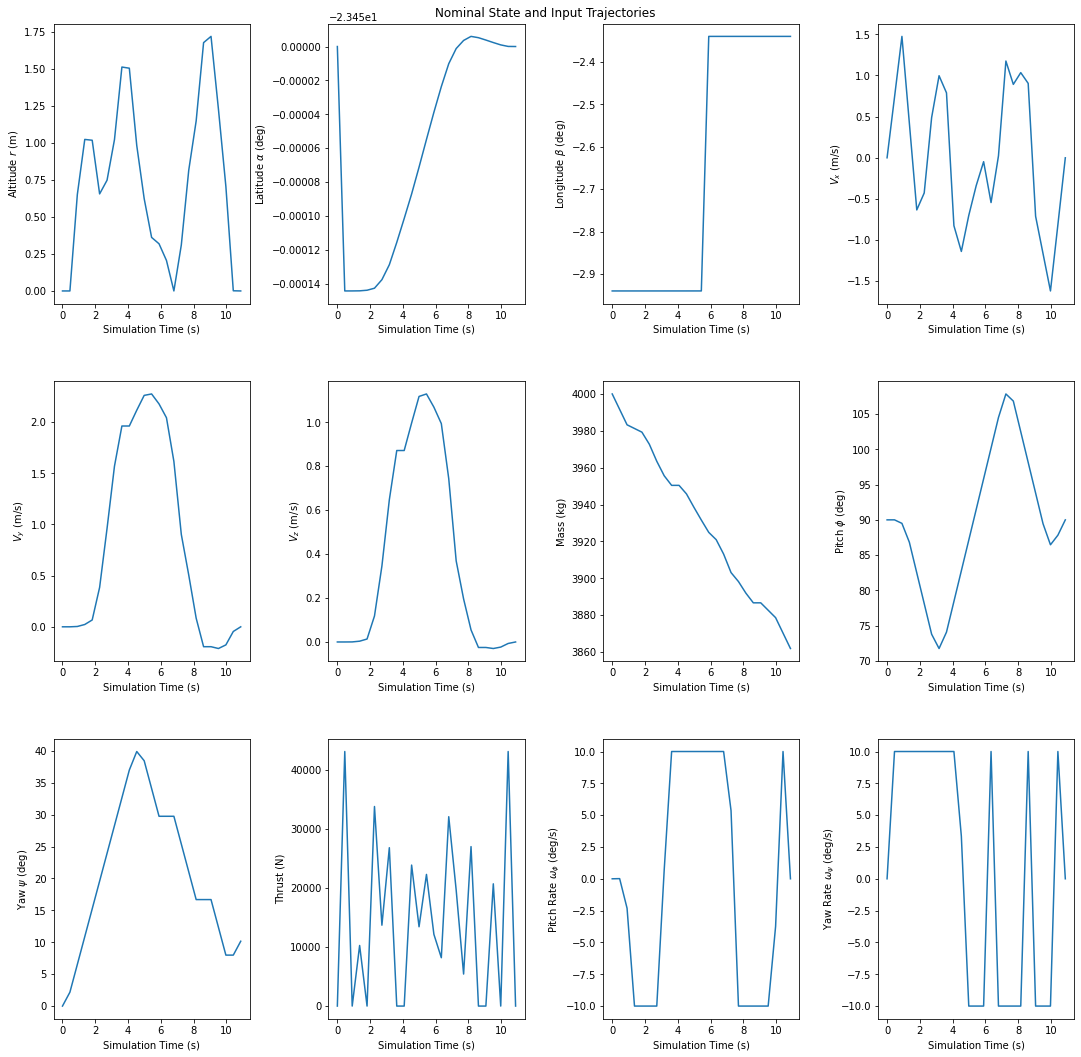

In [129]:
# MUST RUN ONCE PER TRAJECTORY

if dirtrelON:
    x_sol_dirtrel_plot = x_sol_dirtrel
    u_sol_dirtrel_plot = u_sol_dirtrel
    x_sol_dirtrel_plot[:,0] -= r_min
    x_sol_dirtrel_plot[:,1] *= 180/np.pi
    x_sol_dirtrel_plot[:,2] *= 180/np.pi
    x_sol_dirtrel_plot[:,7] *= 180/np.pi
    x_sol_dirtrel_plot[:,8] *= 180/np.pi
    u_sol_dirtrel_plot[:,1] *= 180/np.pi
    u_sol_dirtrel_plot[:,2] *= 180/np.pi
    plot_util(timesteps_dirtrel, x_sol_dirtrel_plot, u_sol_dirtrel_plot,n_x)
else:
    x_sol_dircon_plot = x_sol_dircon
    u_sol_dircon_plot = u_sol_dircon
    x_sol_dircon_plot[:,0] -= r_min
    x_sol_dircon_plot[:,1] *= 180/np.pi
    x_sol_dircon_plot[:,2] *= 180/np.pi
    x_sol_dircon_plot[:,7] *= 180/np.pi
    x_sol_dircon_plot[:,8] *= 180/np.pi
    u_sol_dircon_plot[:,1] *= 180/np.pi
    u_sol_dircon_plot[:,2] *= 180/np.pi
    plot_util(timesteps_dircon, x_sol_dircon_plot, u_sol_dircon_plot,n_x)

In [22]:
if dirtrelON:
    print("Total mass lost:", xinit[N-1, 6] - x_sol_dirtrel[N-1, 6], "kg")
    print("Optimal time: ", N*t_sol_dirtrel)
else:
    print("Total mass lost:", xinit[N-1, 6] - x_sol_dircon[N-1, 6], "kg")
    print("Optimal time: ", N*t_sol_dircon)


Total mass lost: 8.962119089781027 kg
Optimal time:  [10.87495699]


Text(0.5, 0, 'Simulation time (s)')

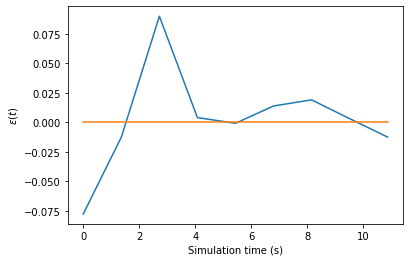

In [147]:
# numerically evaluate dynamics by passing in a continuous polynomial trajectory

# which state to print in the error plot
state_to_plot = 0

vals = []
for i in range(1, int(N*t_sol[0])):
    vals.append(x_traj.derivative(1).value(i)[state_to_plot].item())

densetimesteps = np.linspace(0,N*t_sol[0],len(vals))
x_traj_dot = numeric_eval_dynamics(x_traj,u_traj,t_sol[0],N)

# plt.plot(densetimesteps,vals)
# plt.plot(densetimesteps,x_traj_dot[:,0])

eps = []
for i in range(len(vals)):
    eps.append(vals[i] - x_traj_dot[:,state_to_plot][i])

plt.plot(densetimesteps, eps)
plt.plot(densetimesteps, np.zeros_like(densetimesteps))
plt.ylabel(r"$\epsilon(t)$")
plt.xlabel("Simulation time (s)")

In [123]:
# ONLY run one logger_util then download the .txt immediately
# logger_util(t_sol_dircon, x_sol_dircon, u_sol_dircon, tinit, xinit, uinit)
# logger_util(t_sol_dirtrel, x_sol_dirtrel, u_sol_dirtrel, tinit, xinit, uinit)

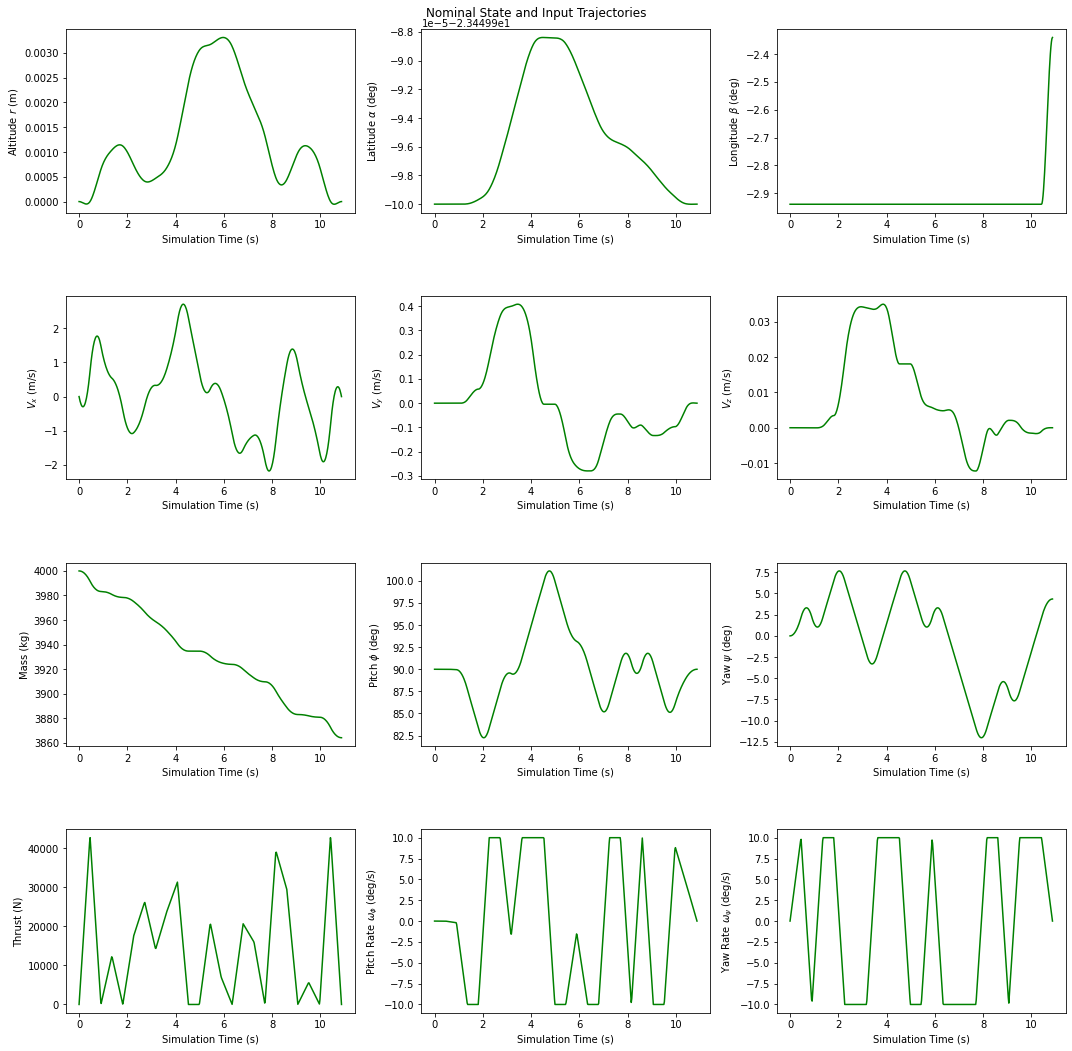

In [27]:
# plot_util_spline(N, t_sol_dircon, x_traj_dircon, u_traj_dircon, n_x, r_min)
plot_util_spline(N, t_sol_dirtrel, x_traj_dirtrel, u_traj_dirtrel, n_x, r_min)

In [ ]:
# doesn't work
# plot_3d_trajectory(x_sol[:,0],x_sol[:,1],x_sol[:,2])

In [23]:
# TODO: create LQR to follow the trajectory
import spacecraft
importlib.reload(spacecraft)
from spacecraft import Spacecraft

import simulation
importlib.reload(simulation)
from simulation import simulate_spacecraft

In [157]:
# LQR and simulation
# refer to beginning of addCost for Q and R
# Run this once per dircon OR dirtrel

Qf = Q
# w_disturb = [0.01,0.5]
w_disturb = [0,0.5]
w_idxs = [3,6]
# R = np.zeros((3,3),int)
# np.fill_diagonal(R,[100,500,300])
# Q = np.zeros((9, 9), int)
# np.fill_diagonal(Q, [100,100,100,100,500,500,100,1000,100])
Q = np.zeros((9, 9), int)
np.fill_diagonal(Q, [10,10,10,10,500,1000,1,1000,10])
R = np.zeros((3,3),int)
np.fill_diagonal(R,[1,500,3])
if dirtrelON:
    spacecraft = Spacecraft(Q,R,Qf,t_sol_dirtrel.item()*N,x_traj_dirtrel,u_traj_dirtrel)
    xsim_dirtrel,usim_dirtrel,tsim_dirtrel = simulate_spacecraft(x_traj_dirtrel.value(0).flatten(),u_traj_dirtrel.value(0).flatten(),t_sol_dirtrel.item()*N,spacecraft,w_disturb,w_idxs)
else:
    spacecraft = Spacecraft(Q,R,Qf,t_sol_dircon.item()*N,x_traj_dircon,u_traj_dircon)
    xsim_dircon,usim_dircon,tsim_dircon = simulate_spacecraft(x_traj_dircon.value(0).flatten(),u_traj_dircon.value(0).flatten(),t_sol_dircon.item()*N,spacecraft,w_disturb,w_idxs)

In [158]:
# comparing errors
# RUN THIS ONCE PER BOTH SIMULATION

# tempx = tsim_dircon
# tempy = xsim_dircon
# tempinter = timesteps_dircon
# fuck = np.interp(tempinter,tempx,tempy)
# print(fuck)

# print(xsim_dirtrel.shape)

# dirconSolState = np.zeros((len(timesteps_dircon),n_x+n_u))
errorDircon = np.zeros((n_x+n_u))
sumDircon = np.zeros((n_x+n_u))
for i,t in enumerate(timesteps_dircon):
    mintidx = (np.abs(tsim_dircon - t)).argmin()
    # print("dircon max",np.max(x_sol_dircon[0]))
    for idx in range(n_x+n_u):
        if idx < n_x:
            # dirconSolState[i,idx] = x_traj_dircon.value(t)[idx]
            # sumDircon[idx] += np.abs(x_traj_dircon.value(t)[idx].item())
            errorDircon[idx] += (np.abs(x_traj_dircon.value(t)[idx].item()) - np.abs(xsim_dircon[mintidx,idx]))**2
            # if idx == 0:
            #     print("dircon r ",xsim_dircon[mintidx,idx])
        else:
            # dirconSolState[i,idx] = u_traj_dircon.value(t)[idx-n_x]
            # sumDircon[idx] += np.abs(u_traj_dircon.value(t)[idx-n_x].item())
            errorDircon[idx] += (np.abs(u_traj_dircon.value(t)[idx-n_x].item()) - np.abs(usim_dircon[mintidx,idx-n_x]))**2

# dirtrelSolState = np.zeros((len(timesteps_dirtrel),n_x+n_u))
errorDirtrel = np.zeros((n_x+n_u))
sumDirtrel = np.zeros((n_x+n_u))
for i,t in enumerate(timesteps_dirtrel):
    # print("dirtrel max",np.max(x_sol_dirtrel[0]))
    mintidx = (np.abs(tsim_dirtrel - t)).argmin() #closest in tsim to t in timestep
    for idx in range(n_x+n_u):
        if idx < n_x:
            # dirtrelSolState[i,idx] = x_traj_dirtrel.value(t)[idx]
            # dirtrelSimStaet[i,idx] = xsim_dirtrel[minidx,idx]
            # sumDirtrel[idx] += np.abs(xsim_dirtrel[mintidx,idx])
            errorDirtrel[idx] += (np.abs(x_traj_dirtrel.value(t)[idx].item()) - np.abs(xsim_dirtrel[mintidx,idx]))**2
            # if idx == 0:
            #     print("dirtrel r ",xsim_dirtrel[mintidx,idx])
        else:
            # dirtrelSolState[i,idx] = u_traj_dirtrel.value(t)[idx-n_x]
            # sumDirtrel[idx] += np.abs(usim_dirtrel[mintidx,idx-n_x])
            errorDirtrel[idx] += (np.abs(u_traj_dirtrel.value(t)[idx-n_x].item()) - np.abs(usim_dirtrel[mintidx,idx-n_x]))**2

# print("r improvement percentage", 100 * (errorDircon[0] - errorDirtrel[0])/(errorDircon[0]))
# print(errorDircon[0])

# print(dirconState)
# lst = np.asarray(lst) 
# idx = (np.abs(lst - K)).argmin() 
# return lst[idx] 
for idx,error in enumerate(errorDirtrel):
    errorDirtrel[idx] = np.sqrt(error)
for idx,error in enumerate(errorDircon):
    errorDircon[idx] = np.sqrt(error)
print("DIRCON cumulative error")
print(errorDircon)
print("----------------------------------------------------------------")
print("DIRTREL cumulative error")
print(errorDirtrel)
print("----------------------------------------------------------------")
print("error differences (positive means DIRCON error is higher, vice versa)")
print(errorDircon - errorDirtrel)



# print("----------------------------------------------------------------")
# print("ratio of sum error divided by sum of DIRCON trajectory")
# print(np.divide((errorDircon - errorDirtrel),sumDircon))
# above is how much error is in the original regular trajectory, the larger
# means DIRTREL is better
#

# print("----------------------------------------------------------------")
# print("ratio of sum error divided by sum")
# # print((errorDircon - errorDirtrel) / sumDirtrel)
# print(np.divide((errorDircon - errorDirtrel),sumDirtrel))

DIRCON cumulative error
[3.81571949e+00 1.58775632e-05 3.62753103e-02 4.80564318e+00
 8.73304610e+00 5.03394112e+00 1.49490988e+02 2.64518949e+00
 1.29673043e+01 6.29612756e+01 3.43460978e+00 1.48044604e+01]
----------------------------------------------------------------
DIRTREL cumulative error
[1.24547902e+00 2.46687648e-07 1.04719315e-02 6.99732150e-01
 1.61926099e-01 3.85501882e-02 2.63838152e+02 5.87580363e-02
 1.78696802e-01 9.34354264e+01 1.33768510e-01 3.22622659e-01]
----------------------------------------------------------------
error differences (positive means DIRCON error is higher, vice versa)
[ 2.57024047e+00  1.56308756e-05  2.58033788e-02  4.10591103e+00
  8.57112000e+00  4.99539093e+00 -1.14347164e+02  2.58643146e+00
  1.27886075e+01 -3.04741508e+01  3.30084127e+00  1.44818378e+01]


In [159]:
# Scale the xsim solutions to the plotting values
# DO NOT run this more than once per both simulation result

# if dirtrelON:
xsim_dirtrel_plot = xsim_dirtrel
usim_dirtrel_plot = usim_dirtrel
xsim_dirtrel_plot[:,0] -= r_min
xsim_dirtrel_plot[:,1] *= 180/np.pi
xsim_dirtrel_plot[:,2] *= 180/np.pi
xsim_dirtrel_plot[:,7] *= 180/np.pi
xsim_dirtrel_plot[:,8] *= 180/np.pi
usim_dirtrel_plot[:,1] *= 180/np.pi
usim_dirtrel_plot[:,2] *= 180/np.pi
# plot_util(timesteps_dirtrel, xsim_dirtrel_plot, usim_dirtrel_plot,n_x)
# else:
xsim_dircon_plot = xsim_dircon
usim_dircon_plot = usim_dircon
xsim_dircon_plot[:,0] -= r_min
xsim_dircon_plot[:,1] *= 180/np.pi
xsim_dircon_plot[:,2] *= 180/np.pi
xsim_dircon_plot[:,7] *= 180/np.pi
xsim_dircon_plot[:,8] *= 180/np.pi
usim_dircon_plot[:,1] *= 180/np.pi
usim_dircon_plot[:,2] *= 180/np.pi
# plot_util(timesteps_dircon, xsim_dircon_plot, usim_dircon_plot,n_x)



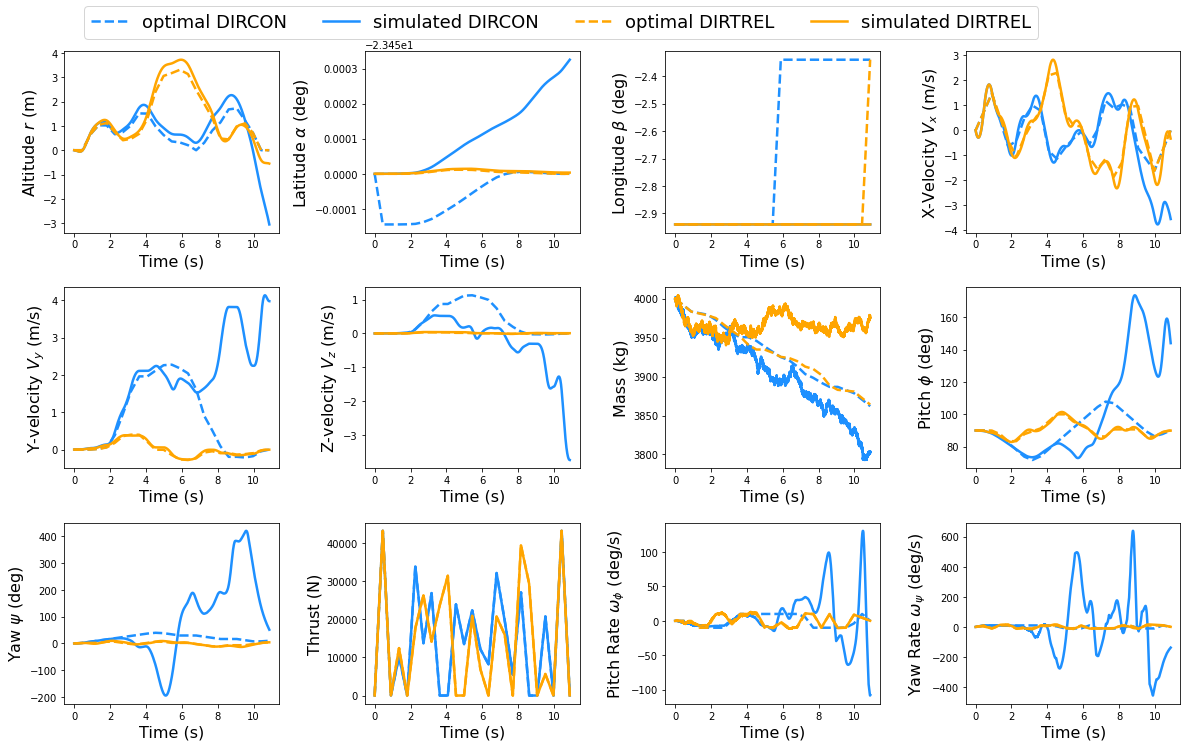

In [160]:
plot_util_overlay_all(timesteps_dircon, x_sol_dircon_plot, u_sol_dircon_plot,\
                      tsim_dircon, xsim_dircon_plot, usim_dircon_plot,\
                      timesteps_dirtrel, x_sol_dirtrel_plot, u_sol_dirtrel_plot, \
                      tsim_dirtrel, xsim_dirtrel_plot, usim_dirtrel_plot, n_x)



In [161]:
Tsum_dircon = 0
Tsum_dirtrel = 0

for i in range(N):
    Tsum_dircon += u_sol_dircon[i,0]*t_sol_dircon
    Tsum_dirtrel += u_sol_dirtrel[i,0]*t_sol_dirtrel

print("DIRCON Thrust Sum",Tsum_dircon)
print("DIRTREL Thrust Sum",Tsum_dirtrel)

DIRCON Thrust Sum [154865.98266185]
DIRTREL Thrust Sum [152531.40106045]


4000.0

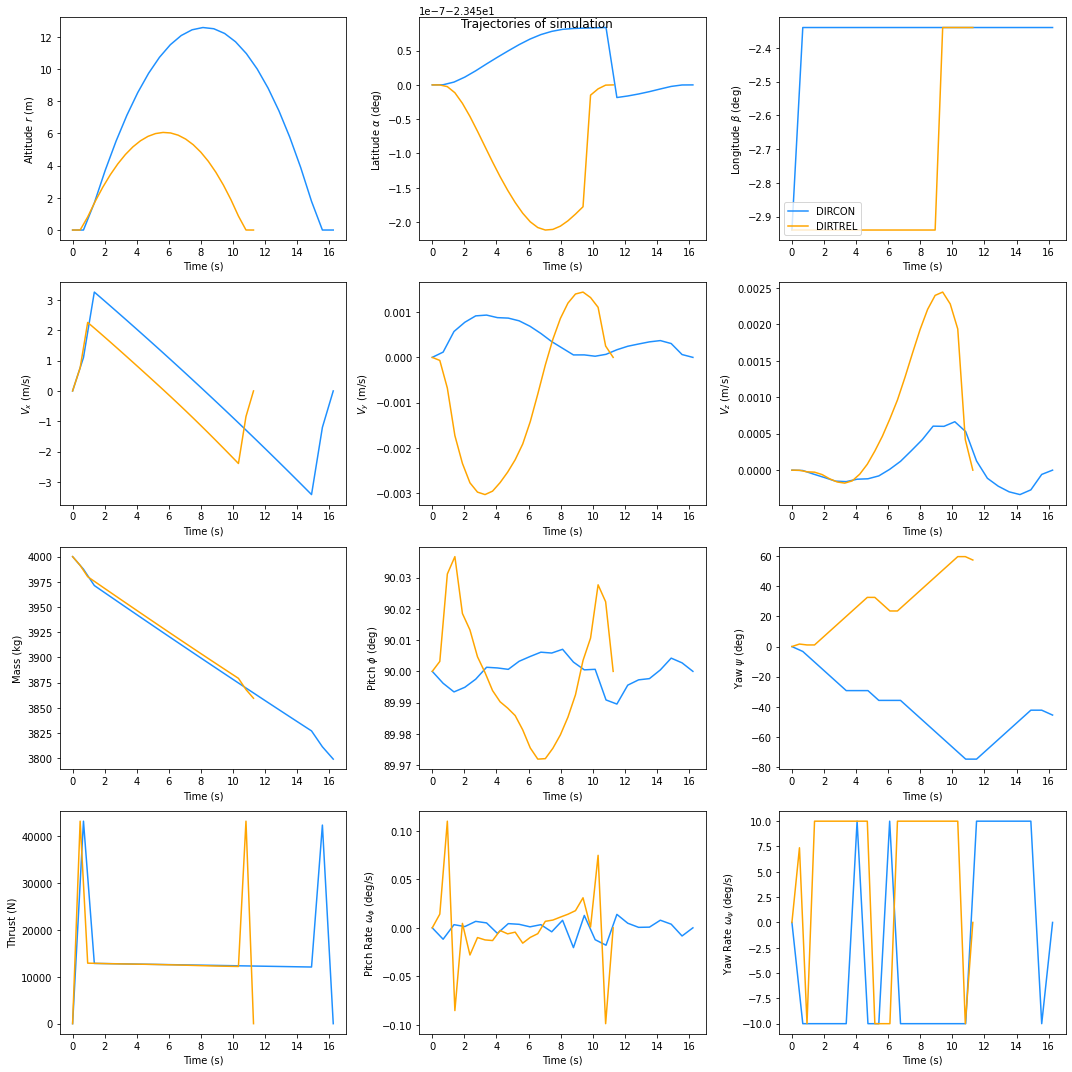

In [ ]:
plot_util_overlay(timesteps_dircon, x_sol_dircon_plot, u_sol_dircon_plot,timesteps_dirtrel,x_sol_dirtrel_plot,u_sol_dirtrel_plot,n_x)

In [ ]:
plt.plot(tsim, xsim[:,1], label='TVLQR')
plt.plot(timesteps, x_sol[:,1])
plt.xlim(0, 200)
plt.xlim(0,30)
plt.legend()

# x = [r, alpha, beta, vx, vy, vz, m, phi, psi]
# u = [T, w_phi, w_psi]

In [ ]:
whos

Variable                    Type                          Data/Info
-------------------------------------------------------------------
AddCollocationConstraints   function                      <function AddCollocationC<...>raints at 0x7fdf8f6f8b70>
AddCost                     function                      <function AddCost at 0x7fdf8f6fbe18>
AddInitialConstraints       function                      <function AddInitialConst<...>raints at 0x7fdf8f6fb400>
AddLandingConstraints       function                      <function AddLandingConst<...>raints at 0x7fdfaa7f6d08>
AddProgCost                 function                      <function AddProgCost at 0x7fdf8f460e18>
AddQuadCost                 function                      <function AddQuadCost at 0x7fdf8f460ea0>
AutoDiffXd                  pybind11_type                 <class 'pydrake.autodiffutils.AutoDiffXd'>
EvaluateDynamics            function                      <function EvaluateDynamics at 0x7fdfaa7f6a60>
Isp                     